# Generalized MLM distribution simulation

In [1]:
library(evd)
library(maxstablePCA)
library(ggplot2)
library(dplyr)
library(GGally)
library(graphicalExtremes)
library(Matrix)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



### setup parameters and simulate data

In [2]:
set.seed(1995)
s <- 100

In [3]:
Z <- rmvevd(10000, dep = 0.99999, model = "log", d = 3, mar = c(1,1,1))

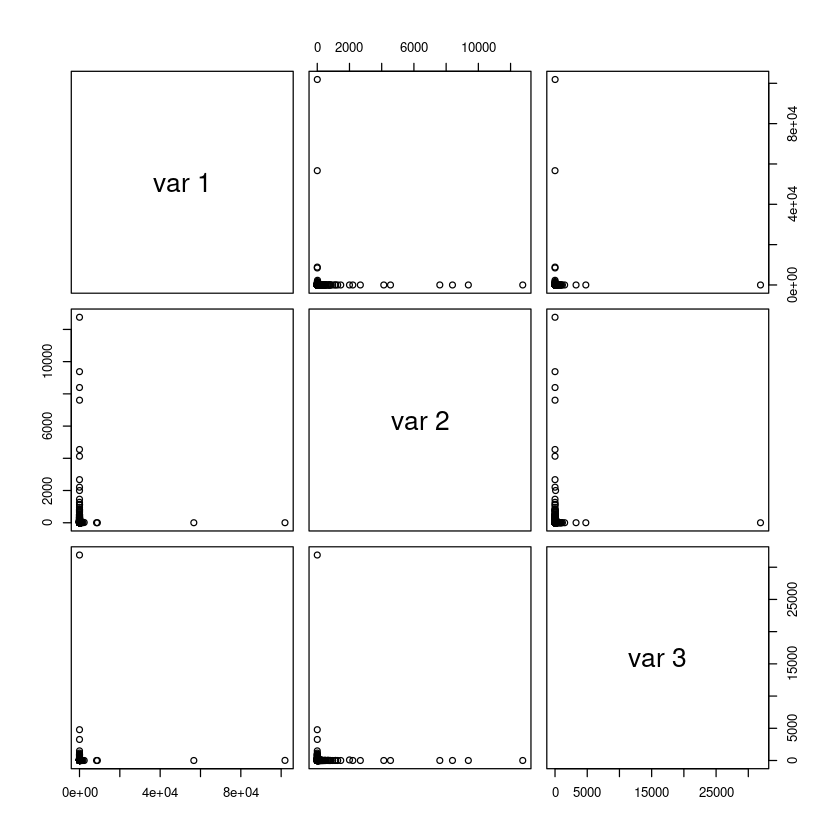

In [4]:
pairs(Z)

In [5]:
A <- matrix(c(1,0,1,1,1,1,0,1,1), 3, 3)
X <- t(maxmatmul(A, t(Z)))

In [6]:
A

1,1,0
0,1,1
1,1,1


In [7]:
Xtrafo <- transform_unitpareto(X)

# max-stable PCA for X

In [8]:
summary(apply(Xtrafo, 1, max))

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
    1.001     1.663     2.718    14.022     5.755 10000.000 

In [9]:
length(which(apply(Xtrafo, 1, max) > s))

[1] 140

In [10]:
maxPCA1 <- max_stable_prcomp(Xtrafo, p = 1, s = s, n_initial_guesses = 15000, norm = "linfty")
maxPCA2 <- max_stable_prcomp(Xtrafo, p = 2, s = s, n_initial_guesses = 15000, norm = "linfty")
maxPCA3 <- max_stable_prcomp(Xtrafo, p = 3, s = s, n_initial_guesses = 15000, norm = "linfty")

### inspect relevant output 

In [11]:
maxPCA2

$p
[1] 2

$d
[1] 3

$decoder_matrix
             [,1]         [,2]
[1,] 1.070660e+00 0.0006776764
[2,] 4.065758e-20 1.0795001186
[3,] 8.341803e-01 0.7296650831

$encoder_matrix
             [,1]         [,2]         [,3]
[1,] 0.9340143946 3.252607e-19 0.0005007717
[2,] 0.0002133994 9.263577e-01 0.0000000000

$reconstr_matrix
             [,1]         [,2]         [,3]
[1,] 1.0000119003 0.0006277708 5.361563e-04
[2,] 0.0002303646 1.0000032940 2.036017e-23
[3,] 0.7791364241 0.6759309000 4.177339e-04

$loss_fctn_value
[1] 0.0337193

$optim_conv_status
[1] 4

$s
[1] 100

$starting_vals
$starting_vals$decoder_matrix_x0
          [,1]      [,2]
[1,] 1.0000000 0.6005396
[2,] 0.1586952 1.0000000
[3,] 0.8626501 0.6439893

$starting_vals$encoder_matrix_x0
          [,1]      [,2]      [,3]
[1,] 0.9015112 0.1458206 0.6063184
[2,] 0.6945187 0.9874111 0.7855360


attr(,"class")
[1] "max_stable_prcomp"

In [12]:
maxPCA3$optim_conv_status

[1] 4

### report rounded estimated matrices

In [13]:
round(maxPCA2$decoder_matrix, 2)

1.07,0.00
0.00,1.08
0.83,0.73


In [14]:
round(maxPCA2$encoder_matrix, 2)

0.93,0.00,0
0.00,0.93,0


In [15]:
round(maxPCA2$reconstr_matrix, 2)

1.00,0.00,0
0.00,1.00,0
0.78,0.68,0


# Elbow plot for reconstruction error 

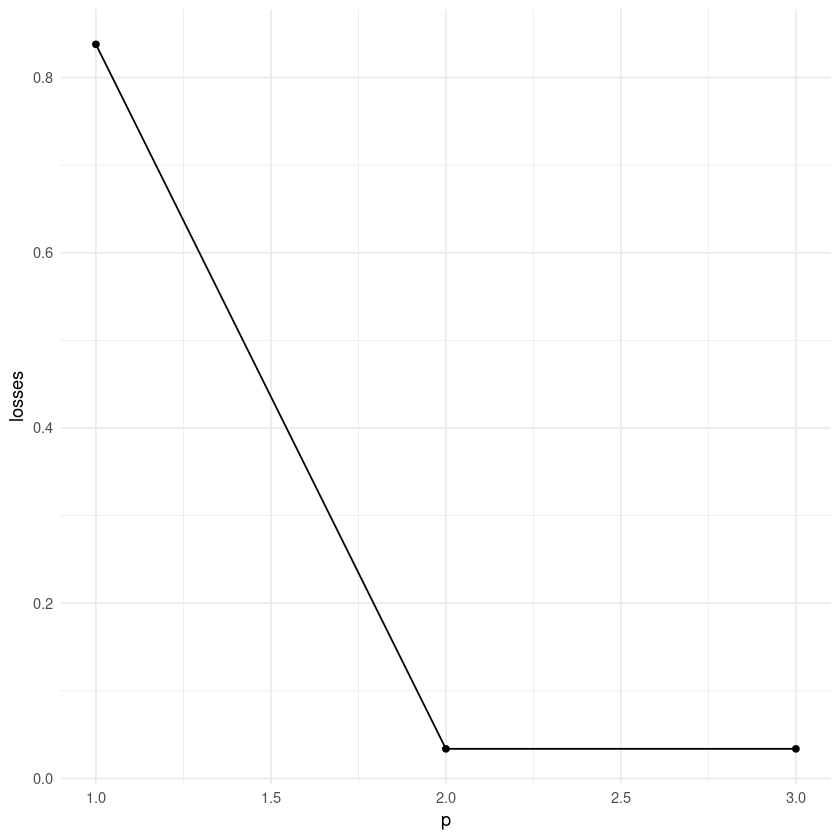

In [16]:
plotdat <- data.frame(p = 1:3, losses = c(
    maxPCA1$loss_fctn_value,
    maxPCA2$loss_fctn_value,
    maxPCA3$loss_fctn_value
))

pe <- ggplot(aes(x = p, y = losses), data = plotdat) + geom_line() + geom_point() + theme_minimal()
pe

In [17]:
ggsave("genmlm_elbow.pdf", pe)

Saving 6.67 x 6.67 in image


# pairplot to visually inspect reconstruction

In [18]:
datX <- data.frame(X)
rec <- t(maxmatmul(maxPCA2$reconstr_matrix, t(as.matrix(datX))))
datX$is_rec = "original"
datrec <- data.frame(rec)
datrec$is_rec = "reconstruction"
names(datrec) <- names(datX)
plot_datX <- full_join(datX, datrec)

Joining with `by = join_by(X1, X2, X3, is_rec)`


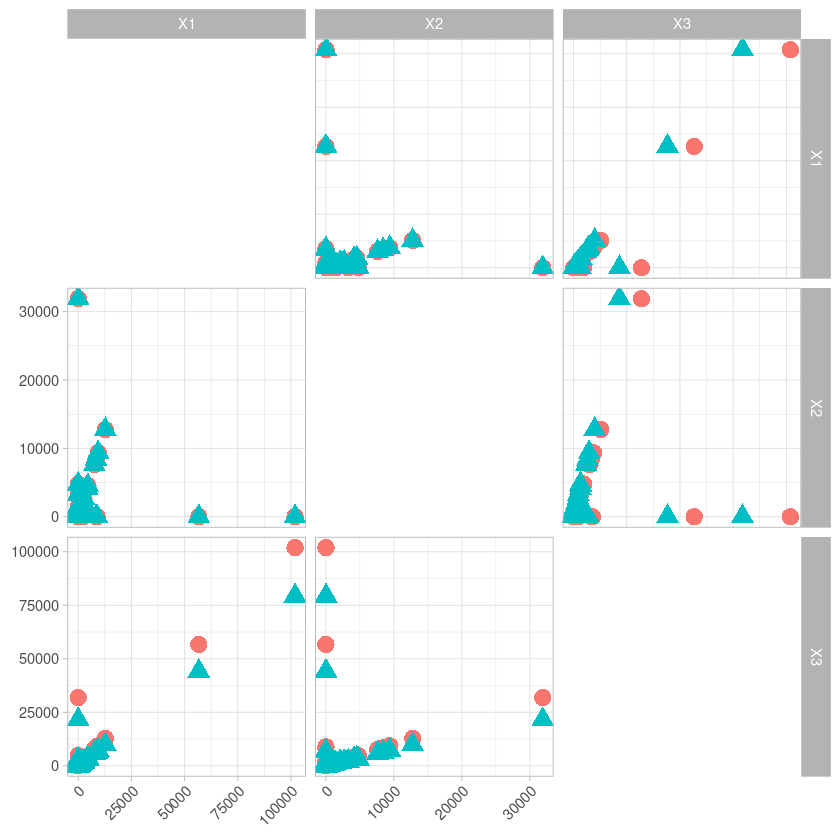

In [19]:
p <- ggpairs(
    plot_datX, 
    aes(color = is_rec, shape = is_rec, size = 2),
    columns = 1:3,
    upper = list(continuous = "points", combo = "dot_no_facet"),
    diag = list(continuous = "blankDiag", discrete = "barDiag", na = "naDiag")
) + 
theme_light() +
theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))

p

In [20]:
plot_datX %>% group_by(is_rec) %>% summarize(max(X1))

is_rec,max(X1)
<chr>,<dbl>
original,101896.5
reconstruction,101897.7


In [21]:
ggsave("genmlm.png", p)

Saving 6.67 x 6.67 in image


# Comparison to other methodologies 

In [22]:
Xsphere1 <- t(apply(Xtrafo, 1, function(z) z / max(z)))
Xsphere1 <- Xsphere1[which(rowSums(Xtrafo) > 250), ]

In [42]:
specdecomp1 <- eigen(t(Xsphere1) %*% Xsphere1 / 24.3)
specdecomp1

eigen() decomposition
$values
[1] 7.7861106 1.0013815 0.1507186

$vectors
           [,1]       [,2]       [,3]
[1,] -0.5843063  0.6408534 -0.4978887
[2,] -0.6129094 -0.7506060 -0.2468456
[3,] -0.5319101  0.1609272  0.8313688


In [24]:
rec1 <- X %*% specdecomp1$vectors[1:3, 1:2] %*% t(specdecomp1$vectors[1:3, 1:2])

plotdat_DS1 <- data.frame(X)
tmp <- data.frame(rec1)
plotdat_DS1 <- full_join(plotdat_DS1, tmp)
plotdat_DS1$is_rec <- c(rep(F, 10000), rep(T, 10000))

Joining with `by = join_by(X1, X2, X3)`


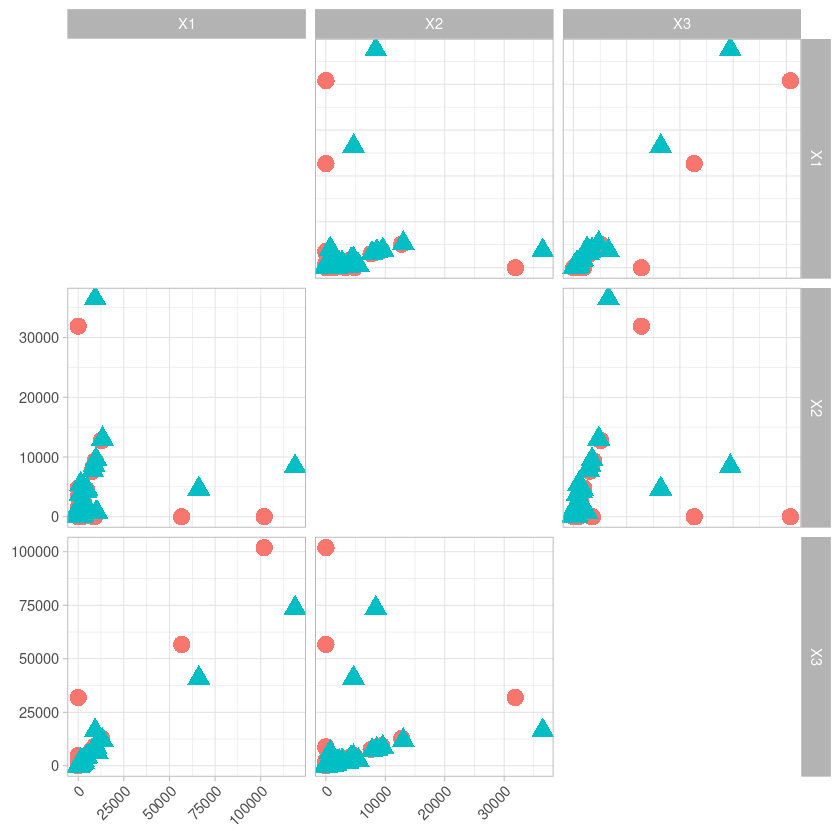

In [25]:
ggpairs(plotdat_DS1,     
        aes(color = is_rec, shape = is_rec, size = 2),
        columns = 1:3,
        upper = list(continuous = "points", combo = "dot_no_facet"),
        diag = list(continuous = "blankDiag", discrete = "barDiag", na = "naDiag")
) + 
theme_light() +
theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))

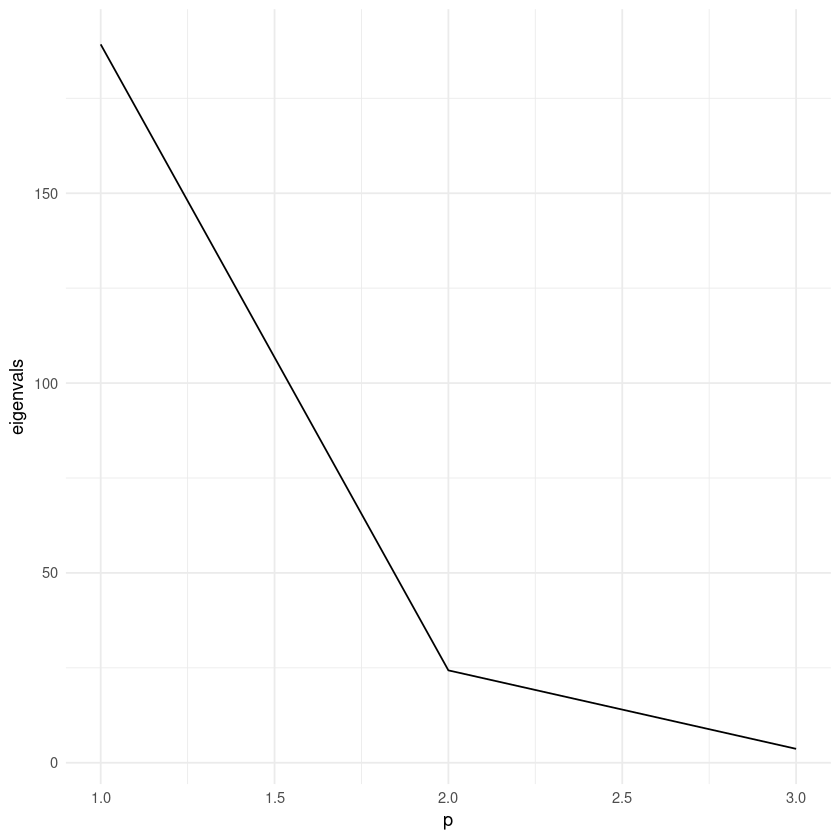

In [26]:
screeplotdat <- data.frame(p = 1:3, eigenvals = specdecomp1$values)

ggplot(aes(x = p, y = eigenvals), data = screeplotdat) + 
geom_line() + 
theme_minimal()

# PCA as by Cooley and Thibaud 

In [27]:
# Tail pairwise dependence matrix code by Yiang 

decls <- function(x, th, k) {
    ## Ordinary decluster.
    id.big <- which(x > th)
    id.dif <- diff(id.big)
    tick <- which(id.dif >= k)
    start <- id.big[c(1, tick + 1)]              # Where a new cluster begins
    end <- c(id.big[tick], last(id.big, 1))
    n <- length(start)
    id.res <- rep(0, n)
    for ( i in 1 : n) {
        temp <- x[start[i] : end[i]]
        id.res[i] <- which(temp == max(temp, na.rm = TRUE))[1] + start[i] - 1
    }
    id.res
}

rw.Sigma <- function(X, u = 0.98, decluster = F) {
    ## Compute TPDM
    P <- ncol(X)                      # Number of stations
    M <- nrow(X)                      # Number of obs
    Sigma <- matrix(0, P, P)
    for ( i in 1 : P) {
        if (i %% 5 == 0) print(i)
        for ( j in 1 : P) {
            r <- sqrt(X[, i] ^ 2 + X[, j] ^ 2)
            w1 <- X[, i] / r
            w2 <- X[, j] / r
            th <- quantile(r, u, na.rm = TRUE)
            if(decluster) {
                id <- decls(r, th, 5)
            } else {
                id <- which(r > th)
            } 
            Sigma[i, j] <- sum(w1[id] * w2[id], na.rm = TRUE) / (length(id)) * 2
        }
    }
    Sigma
}

ecdf_shifted <- function(z) length(z) / (length(z) + 1) * ecdf(z)(z) + 1 / (length(z) + 1)

In [28]:
# Transform data to approximately 2-Fréchet margins 
Xtrafo_2frech <- apply(Xtrafo, 2, function(z) sqrt(-log(ecdf_shifted(z))))

In [29]:
tpdm <- rw.Sigma(Xtrafo_2frech)
# tpdm <- nearPD(tpdm)$mat

In [30]:
specdecomp_cy <- eigen(tpdm)

In [31]:
specdecomp_cy$vectors[,1] <- -specdecomp_cy$vectors[,1]

In [32]:
specdecomp_cy

eigen() decomposition
$values
[1] 2.900886898 0.089443814 0.009669288

$vectors
          [,1]        [,2]       [,3]
[1,] 0.5731630  0.71269213 -0.4044182
[2,] 0.5735474 -0.70139685 -0.4231854
[3,] 0.5852586 -0.01060125  0.8107774


Saving 6.67 x 6.67 in image


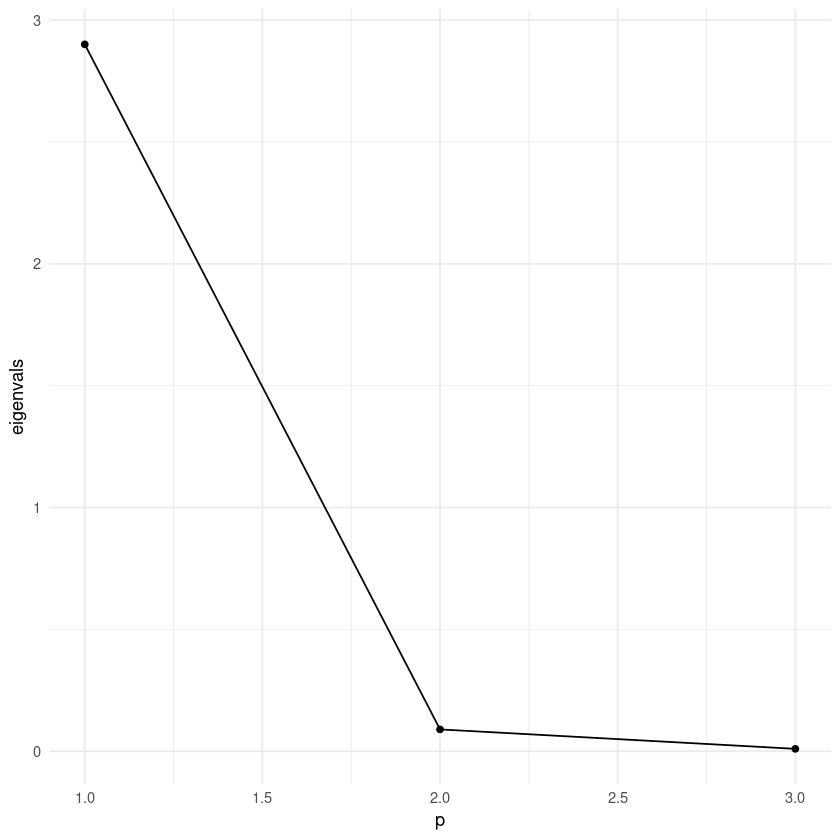

In [33]:
elbow_dat_cy <- data.frame(p = 1:3, eigenvals = specdecomp_cy$values)
elbow_cy <- ggplot(aes(x = p, y = eigenvals), data = elbow_dat_cy) +
geom_line() + 
geom_point () + 
theme_minimal()

ggsave("elbow_epca_cy_genmlm.pdf", elbow_cy)
elbow_cy

In [34]:
##applies the transformation t
trans <- function(x)
{
    ##because it takes an exponential, this function flakes out if x is too big
    ##hence for big values of x, we return x
    v <- log(1 + exp(x))
    id <- which(x < -20)
    v[!is.finite(v)] <- x[!is.finite(v)]
    v[id] <- exp(x[id])
    return(v)
}

##applies the inverse transformation t^{-1}
invTrans <- function(v)
{
    ##same trickeration for big values of v
    ##still returns -Inf if v is machine zero
    x <- log(exp(v) - 1)
    x[!is.finite(x) & v > 1 & !is.na(x)] <- v[!is.finite(x) & v > 1 &
                                                  !is.na(x)]

    return(x)
}

In [35]:
enc_cy <- t(specdecomp_cy$vectors[, 1:2]) %*% t(invTrans(Xtrafo_2frech))
rec_cy <- t(specdecomp_cy$vectors[, 1:2] %*% trans(enc_cy))

Warning message:
“Removed 2 rows containing non-finite outside the scale range
(`stat_density()`).”
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removing 1 row that contained a missing value”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_text()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 2 rows containing non-finite outside the scale range
(`stat_density()`).”


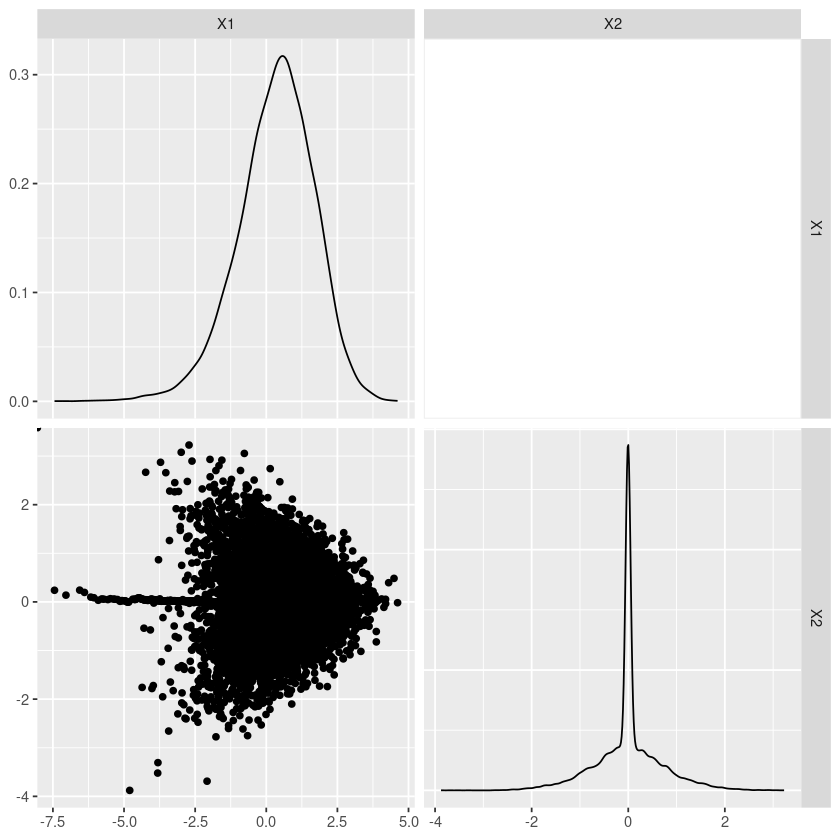

In [36]:
ggpairs(data.frame(t(enc_cy)))

In [37]:
dim(rec_cy)

[1] 10000     3

Joining with `by = join_by(X1, X2, X3)`
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”


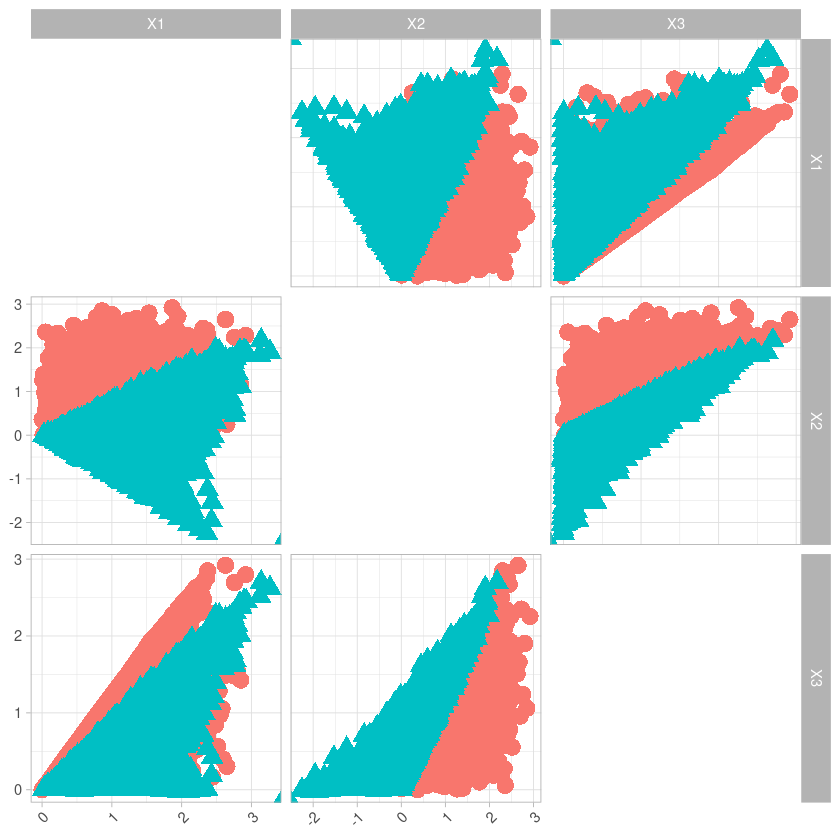

In [38]:
plot_dat <- data.frame(Xtrafo_2frech)
tmp <- data.frame(rec_cy)
plot_dat <- full_join(plot_dat, tmp)
plot_dat$is_rec <- c(rep("False", 10000), rep("True", 10000))


ggpairs(plot_dat,     
        aes(color = is_rec, shape = is_rec, size = 2),
        columns = 1:3,
        upper = list(continuous = "points", combo = "dot_no_facet"),
        diag = list(continuous = "blankDiag", discrete = "barDiag", na = "naDiag")
) + 
theme_light() +
theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))

# Spherical K-means

In [39]:
library(skmeans)

In [40]:
kmeanserrs = data.frame(k = 1:4, errs = NA)
kmeansclusterings = list()
for(k in 2:4) {
    tmp <- skmeans::skmeans(X[which(rowSums(X) > 250), ], k = k)
    kmeansclusterings[[k]] <- tmp
    kmeanserrs[k,2] <- tmp$value
}

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_line()`).”


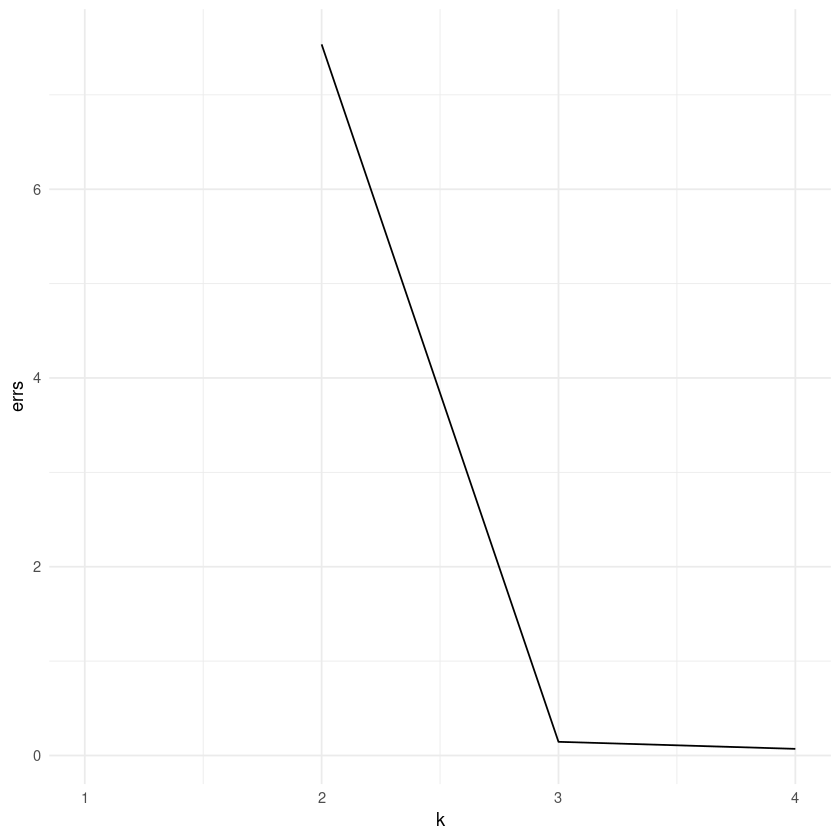

In [41]:
ggplot(aes(x = k, y = errs), data = kmeanserrs) + 
geom_line() +
theme_minimal()